In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir("/content/gdrive/MyDrive/TextClassification")

In [3]:
!pip install -r requirements.txt

     |████████████████████████████████| 325 kB 7.9 MB/s 
     |████████████████████████████████| 4.0 MB 67.8 MB/s 
     |████████████████████████████████| 88 kB 9.1 MB/s 
     |████████████████████████████████| 212 kB 76.0 MB/s 
     |████████████████████████████████| 77 kB 8.8 MB/s 
     |████████████████████████████████| 136 kB 72.1 MB/s 
     |████████████████████████████████| 1.1 MB 60.2 MB/s 
     |████████████████████████████████| 127 kB 78.4 MB/s 
     |████████████████████████████████| 880 kB 69.7 MB/s 
     |████████████████████████████████| 6.6 MB 60.3 MB/s 
     |████████████████████████████████| 596 kB 65.9 MB/s 
     |████████████████████████████████| 1.1 MB 58.7 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
     |████████████████████████████████| 144 kB 76.2 MB/s 
     |████████████████████████████████| 271 kB 79.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=760b3d2752fed98fd44b610f98def97c87533638d407

In [4]:
from datasets import list_datasets
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are {all_datasets[:10]}")

There are 4653 datasets currently available on the Hub
The first 10 are ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [6]:
emotions_dataset = load_dataset("emotion")
emotions_dataset

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

## Analyze dataset

In [7]:
train_ds = emotions_dataset["train"]
print(train_ds[0])
print(train_ds.column_names)
print(train_ds.features)
print(train_ds[:5])

{'text': 'i didnt feel humiliated', 'label': 0}
['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [8]:
emotions_dataset.set_format(type="pandas")
df = emotions_dataset["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [9]:
def label_int2str(row):
  return emotions_dataset["train"].features["label"].int2str(row)

In [10]:
df["label_name"] = df["label"].apply(label_int2str)

In [11]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Class Distribution

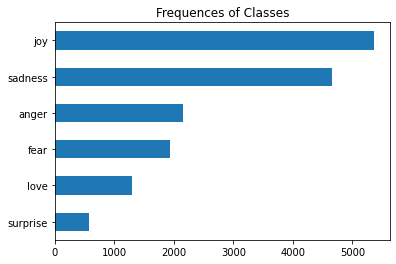

In [12]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequences of Classes")
plt.show()

### Tweets length

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


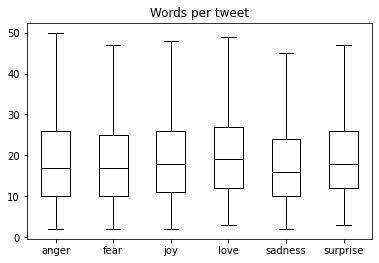

In [13]:
df["Words per tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words per tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [14]:
emotions_dataset.reset_format()

## Tokenization

In [15]:
from transformers import AutoModel, AutoTokenizer
import torch
import numpy as np

In [16]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [18]:
emotions_dataset_encoded = emotions_dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [19]:
emotions_dataset_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [20]:
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state  = model(**inputs).last_hidden_state
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [21]:
emotions_dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_dataset_hidden = emotions_dataset_encoded.map(extract_hidden_states, batched=True)
emotions_dataset_hidden["train"].column_names

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Create feature matrix

In [22]:
X_train = np.array(emotions_dataset_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_dataset_hidden["validation"]["hidden_state"])

y_train = np.array(emotions_dataset_hidden["train"]["label"])
y_valid = np.array(emotions_dataset_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### Visualize training set

In [23]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [24]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a dataframe for 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


,X,Y,label
0,4.600910,6.346628,0
1,-2.831733,6.066186,0
2,5.351050,2.741675,3
3,-2.033411,3.749736,2
4,-3.272627,3.942395,3


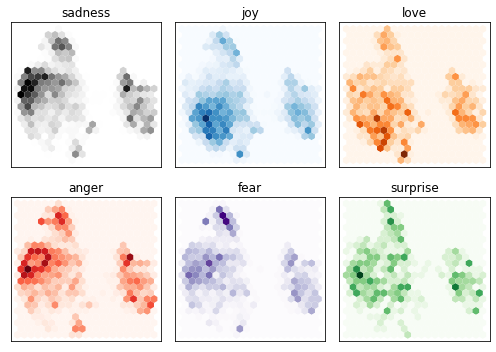

In [25]:
fix, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions_dataset["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### Train a simple classifier

In [26]:
# Increase 'max_iter' to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [27]:
# Compare with a dummy baseline
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [28]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=True)
  plt.title("Normalized confusion matrix")
  plt.show()

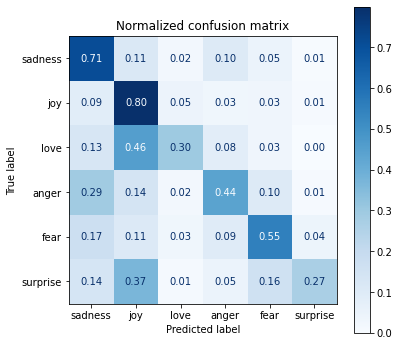

In [29]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-tune Transformers

In [30]:
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from huggingface_hub import notebook_login
from transformers import Trainer, TrainingArguments
from torch.nn.functional import cross_entropy

In [31]:
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

In [32]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [33]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [35]:
batch_size = 64
logging_steps = len(emotions_dataset_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_dataset_encoded["train"],
                  eval_dataset=emotions_dataset_encoded["validation"],
                  tokenizer=tokenizer)

trainer.train()

/content/gdrive/MyDrive/TextClassification/distilbert-base-uncased-finetuned-emotion is already a clone of https://huggingface.co/triet1102/distilbert-base-uncased-finetuned-emotion. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.838200,0.320027,0.901500,0.898260
2,0.255800,0.224645,0.924000,0.924026


Several commits (3) will be pushed upstream.


TrainOutput(global_step=500, training_loss=0.5470035629272461, metrics={'train_runtime': 291.074, 'train_samples_per_second': 109.938, 'train_steps_per_second': 1.718, 'total_flos': 720342861696000.0, 'train_loss': 0.5470035629272461, 'epoch': 2.0})

In [36]:
preds_output = trainer.predict(emotions_dataset_encoded["validation"])

In [37]:
preds_output.metrics

{'test_accuracy': 0.924,
 'test_f1': 0.9240257979590287,
 'test_loss': 0.22464506328105927,
 'test_runtime': 4.4501,
 'test_samples_per_second': 449.429,
 'test_steps_per_second': 7.191}

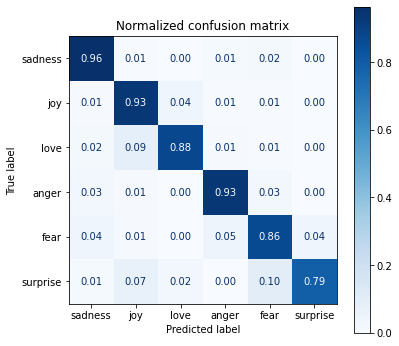

In [38]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

### Analyze error

In [39]:
def forward_pass_with_label(batch):
  inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
  
  # Place outputs on CPU for compatibility with other dataset columns
  return {"loss": loss.cpu().numpy(),
          "predicted_label": pred_label.cpu().numpy()}

In [40]:
# Convert encoded dataset to pytorch tensors
emotions_dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_dataset_encoded["validation"] = emotions_dataset_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [41]:
emotions_dataset_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_dataset_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [43]:
# Samples with highest losses
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.426332
1801,i feel that he was being overshadowed by the s...,love,sadness,5.306253
1950,i as representative of everything thats wrong ...,surprise,sadness,5.271788
465,i would eventually go in to these stores but i...,joy,fear,5.261109
1274,i am going to several holiday parties and i ca...,joy,sadness,5.203821
765,i feel super awkward and out of place right now,joy,sadness,5.011221
1509,i guess this is a memoir so it feels like that...,joy,fear,4.934899
1963,i called myself pro life and voted for perry w...,joy,sadness,4.934595
405,i have been feeling extraordinarily indecisive...,fear,joy,4.736239
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.732594


In [45]:
# Sample with smallest losses
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.015425
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.015689
222,i am at day and i am feeling terrific,joy,joy,0.016072
1226,im feeling terrific and in great shape im opti...,joy,joy,0.016116
1618,i had a good feeling about the presentation an...,joy,joy,0.016118
941,i expected but it did feel hopeful and it defi...,joy,joy,0.016123
205,i cannot wait for school to end so i can chang...,joy,joy,0.016135
1622,i feel that it was a good investment to make t...,joy,joy,0.016155
1418,i am a big believer in the phrase that some pe...,joy,joy,0.016371
856,i feel is more energetic in urban singapore th...,joy,joy,0.016425
